<a href="https://colab.research.google.com/github/YesidORC/Proyecto_DL_2024_1/blob/main/03_Arquitectura_variacion2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
from google.colab import drive

In [2]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False);

replicating local resources


In [3]:
from sklearn.preprocessing import MinMaxScaler

def train_val_test_split(serie, tr_size=0.6, vl_size=0.2, ts_size=0.2 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

def crear_dataset_supervisado(array, input_length, output_length):
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [4]:
file_path="https://raw.githubusercontent.com/YesidORC/Proyecto_DL_2024_1/main/TemperaturaEst202_2013_2022.csv"
df= pd.read_csv(file_path,index_col=0)
df.index = pd.to_datetime(df.index)
df.interpolate(method='time',inplace=True)
tr, vl, ts = train_val_test_split(df['Temperatura'])

In [5]:
# Definición de los INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 48
OUTPUT_LENGTH = 8

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (52532, 48, 1), y_tr: (52532, 8, 1)
Set de validación - x_vl: (17473, 48, 1), y_vl: (17473, 8, 1)
Set de prueba - x_ts: (17475, 48, 1), y_ts: (17475, 8, 1)


In [6]:
data_in = {'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,}
data_s, scaler = escalar_dataset(data_in)
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [10]:
def Recurrent_Model(X_train, OUTPUT_LENGTH, layer_type='SimpleRNN'):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    N_UNITS = 30
    INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])
    model = Sequential()
    if layer_type == 'SimpleRNN':
        model.add(SimpleRNN(N_UNITS,activation = 'relu', return_sequences=True, input_shape=INPUT_SHAPE, name='simple_rnn_layer'))
        model.add(SimpleRNN(N_UNITS,activation = 'relu'))

    if layer_type == 'LSTM':
        model.add(LSTM(N_UNITS, return_sequences=True, input_shape=INPUT_SHAPE, name='lstm_layer'))
        model.add(Dropout(0.2))
        model.add(LSTM(N_UNITS))

    if layer_type == 'GRU':
        model.add(GRU(N_UNITS, return_sequences=True, input_shape=INPUT_SHAPE, name='gru_layer'))
        model.add(Dropout(0.2))
        model.add(GRU(N_UNITS))

    model.add(Dense(OUTPUT_LENGTH))
    return model

def Train_Model(X_train,y_train,xVal,yVal,modelo,op,ls):
  EPOCHS = 25
  BATCH_SIZE = 128
  model = modelo.compile(optimizer=op,loss=ls,metrics=['mean_absolute_error'])
  stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
  historia = modelo.fit(x = X_train,y = y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,validation_data = (xVal, yVal),verbose=2, callbacks=[stop])
  return historia

In [11]:
from tensorflow.keras.optimizers.legacy import RMSprop
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

opt1 = RMSprop(learning_rate=5e-5)
opt2 = 'adam'
opt3 = 'mse'

modelo1 = Recurrent_Model(x_tr_s,OUTPUT_LENGTH,layer_type="SimpleRNN")
historia1 = Train_Model(x_tr_s, y_tr_s, x_vl_s, y_vl_s, modelo1, opt1, root_mean_squared_error)
modelo2 = Recurrent_Model(x_tr_s,OUTPUT_LENGTH,layer_type="GRU")
historia2 = Train_Model(x_tr_s, y_tr_s, x_vl_s, y_vl_s, modelo2, opt1, root_mean_squared_error)
modelo3 = Recurrent_Model(x_tr_s,OUTPUT_LENGTH,layer_type="LSTM")
historia3 = Train_Model(x_tr_s, y_tr_s, x_vl_s, y_vl_s, modelo3, opt1, root_mean_squared_error)

Epoch 1/25
411/411 - 18s - loss: 0.3015 - mean_absolute_error: 0.2402 - val_loss: 0.2796 - val_mean_absolute_error: 0.2257 - 18s/epoch - 44ms/step
Epoch 2/25
411/411 - 9s - loss: 0.2566 - mean_absolute_error: 0.2063 - val_loss: 0.2351 - val_mean_absolute_error: 0.1880 - 9s/epoch - 22ms/step
Epoch 3/25
411/411 - 11s - loss: 0.2130 - mean_absolute_error: 0.1645 - val_loss: 0.1862 - val_mean_absolute_error: 0.1433 - 11s/epoch - 27ms/step
Epoch 4/25
411/411 - 13s - loss: 0.1666 - mean_absolute_error: 0.1245 - val_loss: 0.1470 - val_mean_absolute_error: 0.1098 - 13s/epoch - 32ms/step
Epoch 5/25
411/411 - 11s - loss: 0.1431 - mean_absolute_error: 0.1033 - val_loss: 0.1366 - val_mean_absolute_error: 0.1004 - 11s/epoch - 26ms/step
Epoch 6/25
411/411 - 14s - loss: 0.1364 - mean_absolute_error: 0.0970 - val_loss: 0.1323 - val_mean_absolute_error: 0.0964 - 14s/epoch - 33ms/step
Epoch 7/25
411/411 - 9s - loss: 0.1330 - mean_absolute_error: 0.0937 - val_loss: 0.1297 - val_mean_absolute_error: 0.093

In [12]:
valMae1 = historia1.history["val_mean_absolute_error"]
print("FINAL MAE SimpleRNN: ", np.mean(valMae1))

valMae2 = historia2.history["val_mean_absolute_error"]
print("FINAL MAE GRU:    ", np.mean(valMae2))

valMae3 = historia3.history["val_mean_absolute_error"]
print("FINAL MAE LSTM:   ", np.mean(valMae3))

FINAL MAE SimpleRNN:  0.1009020084142685
FINAL MAE GRU:     0.11209217101335525
FINAL MAE LSTM:    0.10952044993638993


In [13]:
rmse_tr = modelo1.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo1.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo1.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)
print('Comparativo desempeños SIMPLERNN:')
print(f'  RMSE train:\t {rmse_tr}')
print(f'  RMSE val:\t {rmse_vl}')
print(f'  RMSE test:\t {rmse_ts}')

rmse_tr = modelo2.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo2.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo2.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)
print('Comparativo desempeños GRU:')
print(f'  RMSE train:\t {rmse_tr}')
print(f'  RMSE val:\t {rmse_vl}')
print(f'  RMSE test:\t {rmse_ts}')

rmse_tr = modelo3.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo3.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo3.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)
print('Comparativo desempeños LSTM:')
print(f'  RMSE train:\t {rmse_tr}')
print(f'  RMSE val:\t {rmse_vl}')
print(f'  RMSE test:\t {rmse_ts}')

Comparativo desempeños SIMPLERNN:
  RMSE train:	 [0.11401018500328064, 0.0826689600944519]
  RMSE val:	 [0.11609061807394028, 0.08346731960773468]
  RMSE test:	 [0.1182154193520546, 0.08420804142951965]
Comparativo desempeños GRU:
  RMSE train:	 [0.11660224199295044, 0.08548538386821747]
  RMSE val:	 [0.11798939108848572, 0.08618225902318954]
  RMSE test:	 [0.11940553784370422, 0.08573745936155319]
Comparativo desempeños LSTM:
  RMSE train:	 [0.12433359771966934, 0.09405992180109024]
  RMSE val:	 [0.12564152479171753, 0.09463869780302048]
  RMSE test:	 [0.12585359811782837, 0.09362322837114334]


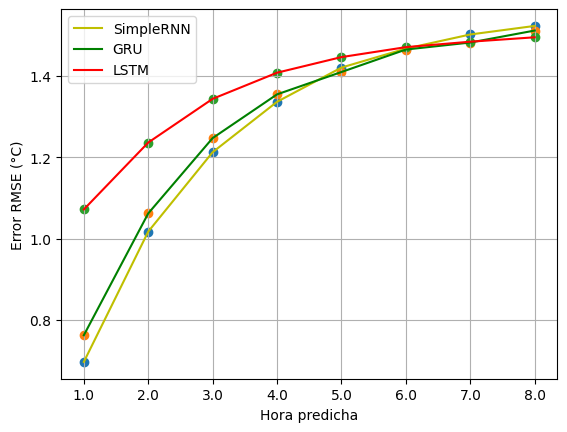

In [17]:
#  Se hace una comparación de las 8 hora predichas
y_ts_pred_s1 = modelo1.predict(x_ts_s, verbose=3)
y_ts_pred1 = scaler.inverse_transform(y_ts_pred_s1)
y_ts_pred_s2 = modelo2.predict(x_ts_s, verbose=3)
y_ts_pred2 = scaler.inverse_transform(y_ts_pred_s2)
y_ts_pred_s3 = modelo3.predict(x_ts_s, verbose=3)
y_ts_pred3 = scaler.inverse_transform(y_ts_pred_s3)

diff_cuad1 = np.square(y_ts.squeeze()-y_ts_pred1)
proms1 = np.mean(diff_cuad1, axis=0)
rmse1 = np.sqrt(proms1)

diff_cuad2 = np.square(y_ts.squeeze()-y_ts_pred2)
proms2 = np.mean(diff_cuad2, axis=0)
rmse2 = np.sqrt(proms2)

diff_cuad3 = np.square(y_ts.squeeze()-y_ts_pred3)
proms3 = np.mean(diff_cuad3, axis=0)
rmse3 = np.sqrt(proms3)

# Graficar rmse para cada timestep
t = np.linspace(1,8,8)

fig, ax = plt.subplots()
ax.plot(t,rmse1,'y',label="SimpleRNN")
ax.scatter(t,rmse1)
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE (°C)')
plt.xticks(ticks=t, labels=t)
plt.grid()
ax.plot(t,rmse2,'g',label = "GRU")
ax.scatter(t,rmse2)
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE (°C)')
plt.xticks(ticks=t, labels=t)
plt.grid()
ax.plot(t,rmse3,'r',label="LSTM")
ax.scatter(t,rmse3)
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE (°C)')
plt.xticks(ticks=t, labels=t)
plt.legend()
plt.grid()

In [18]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('Epoch')
  ax.legend(['training', 'validation'])

# plt.subplots(figsize=(8,5))
# plt.tight_layout()
# display_training_curves(model.history['mean_absolute_error'], model.history['val_mean_absolute_error'], 'Mean_absolute_error', 211)
# display_training_curves(model.history['loss'], model.history['val_loss'], 'loss', 212)
# plt.subplots_adjust(hspace=0.5)

<ipython-input-18-56e44ed38db9>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


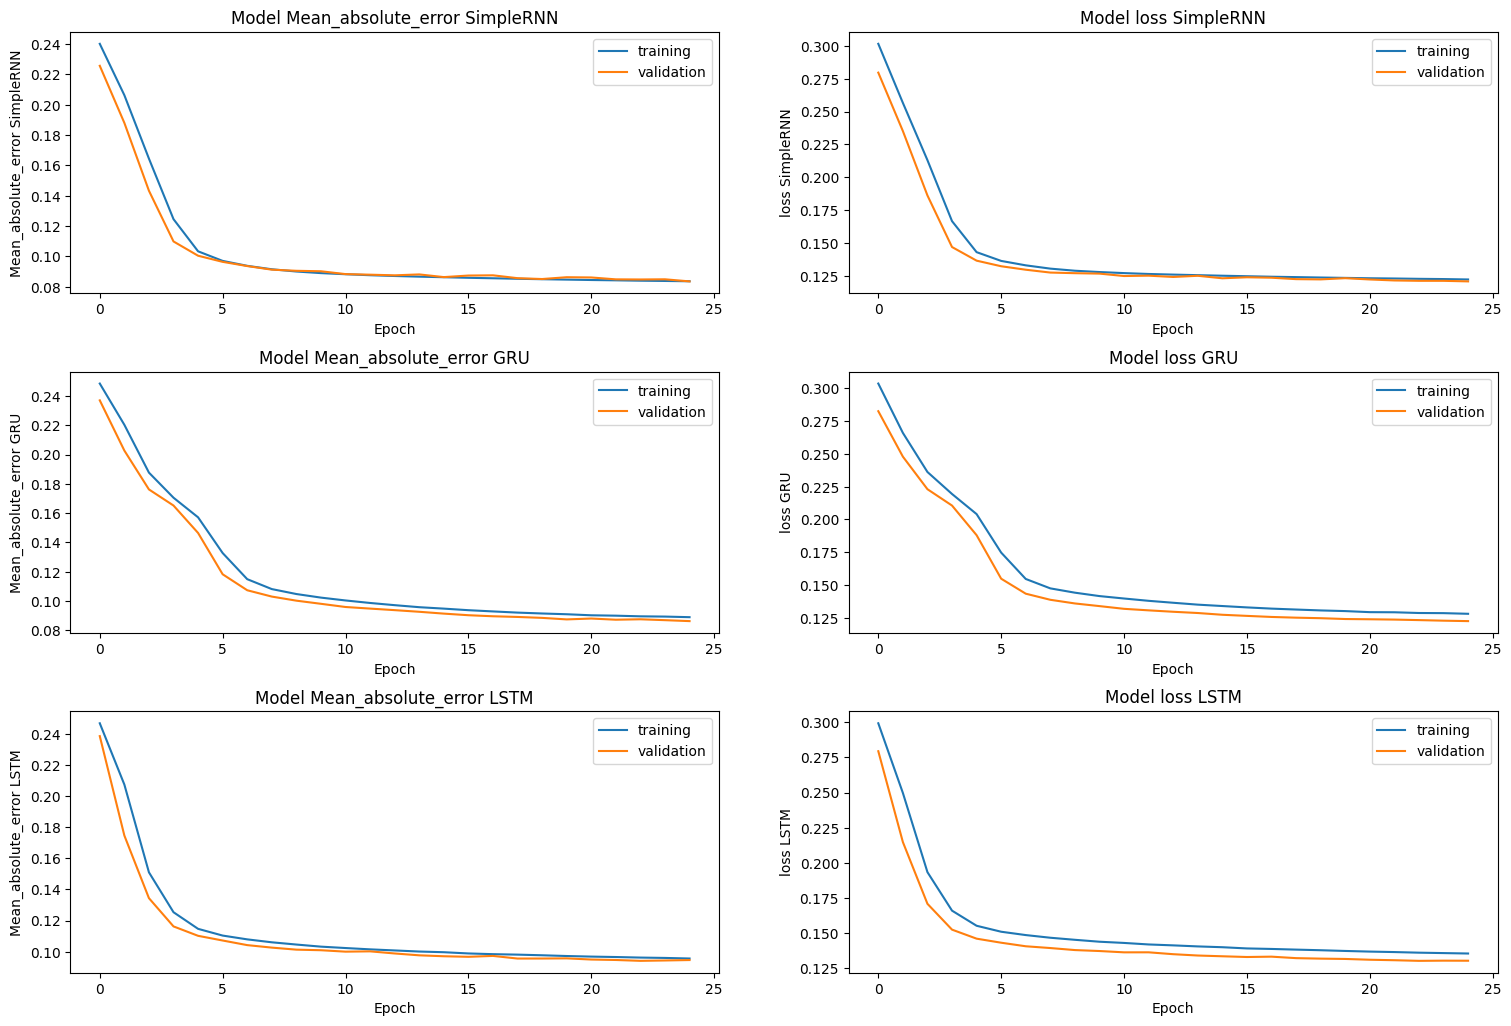

In [19]:
plt.subplots(figsize=(15,10))
plt.tight_layout()
display_training_curves(historia1.history['mean_absolute_error'], historia1.history['val_mean_absolute_error'], 'Mean_absolute_error SimpleRNN', 321)
display_training_curves(historia1.history['loss'], historia1.history['val_loss'], 'loss SimpleRNN', 322)
display_training_curves(historia2.history['mean_absolute_error'], historia2.history['val_mean_absolute_error'], 'Mean_absolute_error GRU', 323)
display_training_curves(historia2.history['loss'], historia2.history['val_loss'], 'loss GRU', 324)
display_training_curves(historia3.history['mean_absolute_error'], historia3.history['val_mean_absolute_error'], 'Mean_absolute_error LSTM', 325)
display_training_curves(historia3.history['loss'], historia3.history['val_loss'], 'loss LSTM', 326)
plt.subplots_adjust(hspace=0.3)

In [21]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

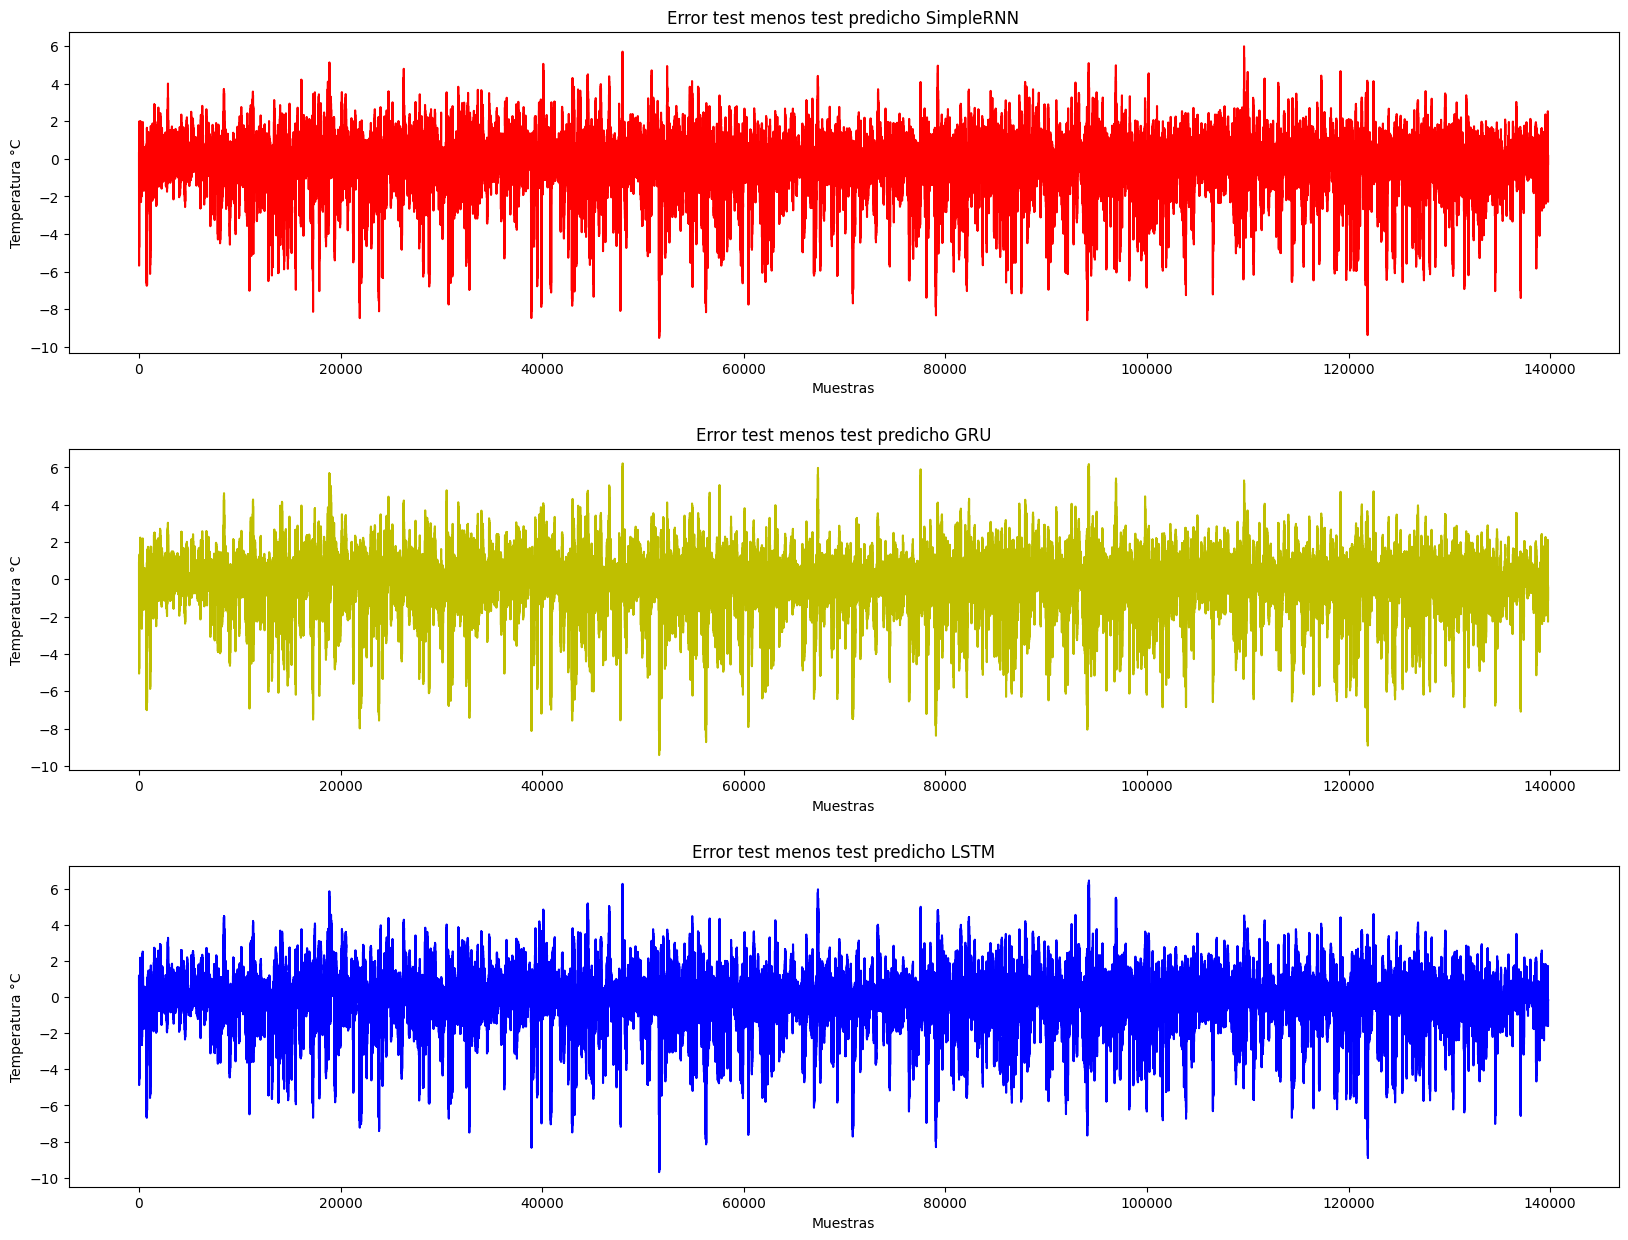

In [22]:
y_ts_pred1 = predecir(x_ts_s, modelo1, scaler)
y_ts_pred2 = predecir(x_ts_s, modelo2, scaler)
y_ts_pred3 = predecir(x_ts_s, modelo3, scaler)
errores1 = y_ts.flatten()-y_ts_pred1
errores2 = y_ts.flatten()-y_ts_pred2
errores3 = y_ts.flatten()-y_ts_pred3
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(errores1,"r")
plt.ylabel("Temperatura °C")
plt.xlabel("Muestras")
plt.title("Error test menos test predicho SimpleRNN")
plt.subplot(312)
plt.plot(errores2,"y")
plt.ylabel("Temperatura °C")
plt.xlabel("Muestras")
plt.title("Error test menos test predicho GRU")
plt.subplot(313)
plt.plot(errores3,"b")
plt.ylabel("Temperatura °C")
plt.xlabel("Muestras")
plt.title("Error test menos test predicho LSTM")
plt.subplots_adjust(hspace=0.3)